In [1]:
%pylab inline
import read_eagle
import h5py
h5py.enable_ipython_completer()

#selecting the file
generic_name = '/cosma7/data/Eagle/ScienceRuns/Planck1/L0100N1504/PE/REFERENCE/data/'
specific_name = ['groups_012_z003p017/eagle_subfind_tab_012_z003p017.']

#these are generalised in case specific_name contains more than one file
FirstSubhaloID = [[] for i in range(len(specific_name))]  #main halos
Pos = [[] for i in range(len(specific_name))]  #positions
SFR = [[] for i in range(len(specific_name))]  #SFR
M200 = [[] for i in range(len(specific_name))]  #Mass inside the radius where the mean density is higher than 200 the critical density of the Universe
MassType = [[] for i in range(len(specific_name))]   #Mass
redshift = []  #Redshift
R200 = [[] for i in range(len(specific_name))] #Radius inside of which the mean density os higher than 200 the critical density

#open a file just to make the program work
myfile1 = generic_name+specific_name[0]+'0.hdf5'
myfile = h5py.File(myfile1, 'r')

#read data
for i in range(len(specific_name)):
    filename = generic_name + specific_name[i] + '0.hdf5'
    myfile = h5py.File(filename, 'r')
    NumFilesPerSnapshot = myfile['Header'].attrs['NumFilesPerSnapshot']
    print(NumFilesPerSnapshot)

    for j in range(NumFilesPerSnapshot):
        
        filename = generic_name + specific_name[i] + '%d.hdf5' %j
        myfile = h5py.File(filename, 'r')
        
        FirstSubhaloID[i].extend(myfile['FOF/FirstSubhaloID'][()])
        Pos[i].append(myfile['Subhalo/CentreOfMass'][()])
        SFR[i].extend(myfile['Subhalo/StarFormationRate'][()])
        M200[i].extend(myfile['FOF/Group_M_Crit200'][()]* 1e10) 
        MassType[i].append(myfile['Subhalo/MassType'][()] * 1e10)
        R200[i].extend(myfile['FOF/Group_R_Crit200'][()]* 3.085678e+24)
        if j==0:
            redshift.append(myfile['Header'].attrs['Redshift'])
        
        myfile.close()

Populating the interactive namespace from numpy and matplotlib
1536


In [2]:
#shaping the arrays
for i in range(len(specific_name)):
    Pos[i] = np.vstack(Pos[i])
    MassType[i] = np.vstack(MassType[i])
    print(Pos[i].shape)
    print(MassType[i].shape)

    SFR[i] = np.asarray(SFR[i])
    M200[i] = np.asarray(M200[i])
    R200[i] = np.asarray(R200[i])
    
print(np.shape(SFR), np.shape(M200))

(3069221, 3)
(3069221, 6)
(1, 3069221) (1, 2595893)


In [4]:
snap = read_eagle.EagleSnapshot("/cosma7/data/Eagle/ScienceRuns/Planck1/L0100N1504/PE/REFERENCE/data/snapshot_012_z003p017/snap_012_z003p017.0.hdf5")
delta_c = 0.2

num_halos=2
#np.random.seed(99)
#halos_ind = np.random.randint(0, len(Pos[0]), num_halos)
halos_ind=[0,72257]

pos_part = []
temp = []
density = []
metallicity = []

for i in halos_ind:
    snap = read_eagle.EagleSnapshot("/cosma7/data/Eagle/ScienceRuns/Planck1/L0100N1504/PE/REFERENCE/data/snapshot_012_z003p017/snap_012_z003p017.0.hdf5")
    delta_c = 0.3
    snap.select_region(Pos[0][i,0]-delta_c, Pos[0][i,0]+delta_c, Pos[0][i,1]-delta_c, Pos[0][i,1]+delta_c, Pos[0][i,2]-delta_c, Pos[0][i,2]+delta_c)
    pos_part.append(snap.read_dataset(0, "Coordinates"))#0 = particle type
    temp.append(snap.read_dataset(0, "Temperature"))
    density.append(np.array(snap.read_dataset(0, "Density")))
    metallicity.append(np.array(snap.read_dataset(0, "Metallicity")))
    #ids.append(np.array(snap.read_dataset(0, "ParticleIDs")))
    del snap

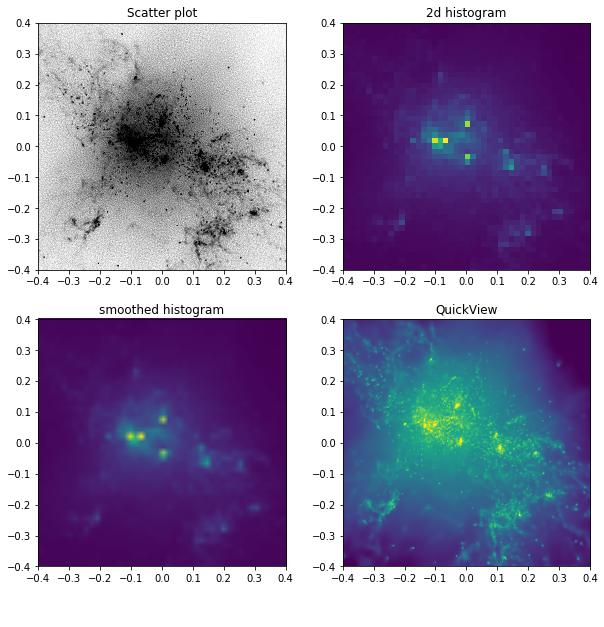

In [5]:
#visualizing the positions

fig, ax = plt.subplots(2,2, figsize=(10,10), subplot_kw={'aspect': 'equal'})
ax = ax.reshape(-1)

from sphviewer.tools import QuickView
from matplotlib.image import NonUniformImage

#scattering plot
ax[0].plot(pos_part[0][:,0]- Pos[0][halos_ind[0],0], pos_part[0][:,1]-Pos[0][halos_ind[0],1], '.k', markersize=0.018)
ax[0].set_xlim(-0.4, 0.4)
ax[0].set_ylim(-0.4, 0.4)
ax[0].set_title('Scatter plot')

#2d histogram
dens_pos, xedges, yedges = np.histogram2d(pos_part[0][:,0] - Pos[0][halos_ind[0],0], pos_part[0][:,1]- Pos[0][halos_ind[0],1], bins=60)
dens_pos = dens_pos.T
ax[1].imshow(dens_pos, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax[1].set_xlim(-0.4, 0.4)
ax[1].set_ylim(-0.4, 0.4)
ax[1].set_title('2d histogram')

#smoothed histogram
im = NonUniformImage(ax[2], interpolation='bilinear', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
im.set_data(xcenters, ycenters, dens_pos)
ax[2].set_xlim(-0.4, 0.4)
ax[2].set_ylim(-0.4, 0.4)
ax[2].add_image(im)
ax[2].set_title('smoothed histogram')

#quickview
qv = QuickView(pos_part[0]- Pos[0][halos_ind[0]], r = 'infinity', plot=False)
img = qv.get_image()
ext = qv.get_extent()
ax[3].imshow(img, origin='lower', extent=ext, clim=[5.5,7.5])
ax[3].set_xlim(-0.4, 0.4)
ax[3].set_ylim(-0.4, 0.4)
ax[3].set_title('QuickView')
plt.show()

[0, 72257]


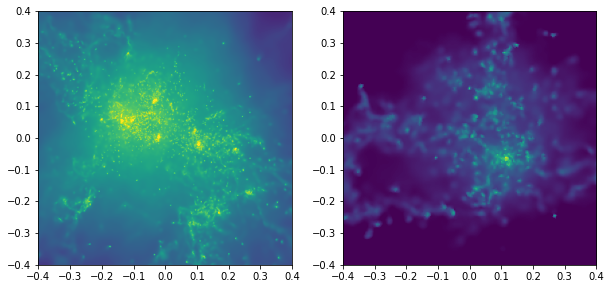

In [6]:
#comparing two halos
fig, ax = plt.subplots(1,2, figsize=(10,5), subplot_kw={'aspect': 'equal'})
from sphviewer.tools import QuickView

print(halos_ind)
for i in range(2):
    qv = QuickView(pos_part[i]- Pos[0][halos_ind[i]], r = 'infinity', plot=False)
    img = qv.get_image()
    ext = qv.get_extent()
    ax[i].imshow(img, extent=ext, origin='lower', clim=[5,7.5])
    ax[i].set_xlim(-0.4, 0.4)
    ax[i].set_ylim(-0.4, 0.4)

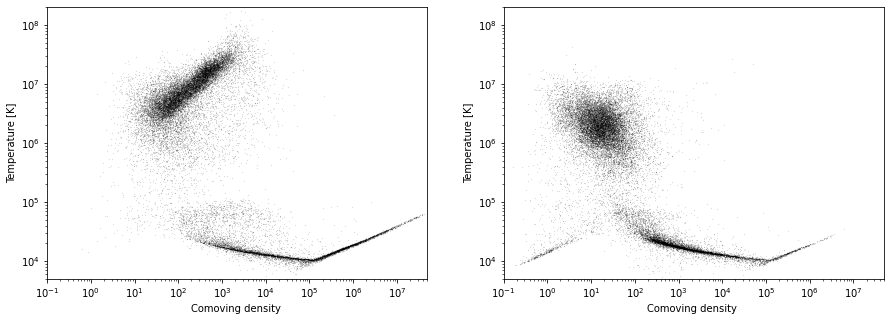

In [7]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

x_axis = np.logspace(5, 7.5, 10)

for i in range(2):
    ind = np.random.randint(0, len(temp[i]), 25000)
    ax[i].plot(density[i][ind], temp[i][ind], '.k', markersize=0.1)
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlim(1e-1, 5e7)
    ax[i].set_ylim(5e3, 2e8)
    ax[i].set_ylabel('Temperature [K]')
    ax[i].set_xlabel('Comoving density ')
    #ax[i].plot(x_axis, x_axis**(1/3)*200)

In the previous plots temperature-density there is a cluster of points at low density and high temperature that are the particles in the CGM. These particles are distributed around a given virial temperature that changes depending on the halo, e.g. in the case of a bigger halo the temperature is higher!

When particles are accreting onto the halo they get shock heated and they reach the equilibrium at the virial temperature. The environment can get denser, recombination occurs more often, atoms are becoming neutral and colder, since with the lack of free electrons collisions are becoming more and more rare. This process generate the gap between the two big clusters. 

High densities combined with low temperatures trigger star formation in the simulation, and it evolves following a polytropic equation involving pressure, temperature and density. In the simulation during star formation the Jeans Mass is indepedent on density, therefore we may notice that a given relation between temperature and density is needed (and it should be $T \propto n^{1/3}$ (?) but check!).

8.732826961566076e-11 6.253344e-05 0.0015218545449897647


(array([5.34403164e+02, 2.60030345e+01, 1.49759304e+01, 9.28468327e+00,
        6.06803157e+00, 4.07387485e+00, 2.86454609e+00, 1.86746686e+00,
        1.34424707e+00, 1.06782846e+00, 8.19382403e-01, 6.94335302e-01,
        6.05487398e-01, 5.38027592e-01, 5.03475934e-01, 4.96893984e-01,
        5.11702083e-01, 4.75505049e-01, 4.98539328e-01, 4.36016244e-01,
        4.42598125e-01, 4.65632972e-01, 4.27790009e-01, 3.61975338e-01,
        3.01098353e-01, 3.04389045e-01, 2.15539860e-01, 2.05668274e-01,
        1.46435811e-01, 1.33273041e-01, 1.23400683e-01, 1.08592849e-01,
        8.72033481e-02, 7.23950675e-02, 6.41685014e-02, 5.75871167e-02,
        4.60696933e-02, 3.94882186e-02, 3.94883086e-02, 2.30347942e-02,
        2.30348991e-02, 1.48080820e-02, 4.93602733e-03, 1.31627995e-02,
        1.31627395e-02, 3.29069987e-03, 4.93602733e-03, 1.64534244e-03,
        3.29069987e-03, 1.64534244e-03]),
 array([0.        , 0.00163591, 0.00327181, 0.00490772, 0.00654363,
        0.00817953, 0.0098

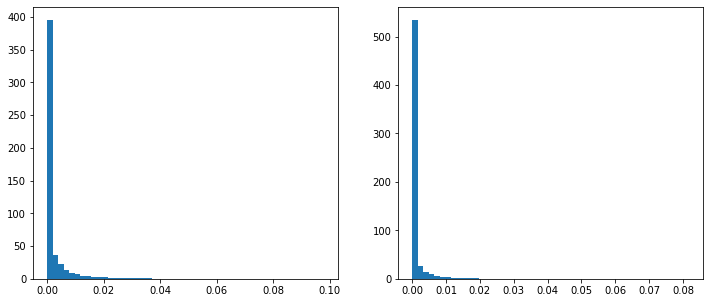

In [19]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

ax[0].hist((metallicity[0]), bins=50, density=True)
print(np.percentile(metallicity[0],25), np.median(metallicity[0]), np.percentile(metallicity[0], 75))
ax[1].hist((metallicity[1]), bins=50, density=True)

In [20]:
print(NumFilesPerSnapshot)

1536
